In [18]:
import numpy as np
import pandas as pd
import loadData
import monteCarloClass
import time

In [19]:
data, dataName = loadData.loadData("dt_all.csv")

intensityVariable = "deltaDurS"
sensoryVar = "audNoise"
standardVar = "standardDur"
conflictVar = "conflictDur"

visualStandardVar = "unbiasedVisualStandardDur"
visualTestVar = "unbiasedVisualTestDur"
audioStandardVar = "standardDur"
audioTestVar = "testDurS"


 Total trials before cleaning
: 2226
uniqueSensory: [0.1 1.2] 
 uniqueStandard: [0.5] 
 uniqueConflict: [-0.25, -0.17, -0.08, 0.0, 0.08, 0.17, 0.25]

0  trials with testDurSCheck False
0  trials with standardDurCheck False

0  trials with abs(testDurSCompare) > 0.05
0  trials with abs(standardDurCompare) > 0.05

0  trials with testDurSCheckBias False
0  trials with negative visual test duration
0  trials with negative visual standard duration
testdurCompare > 0.05: 0 trials
0  trials with negative visual standard duration
0  trials with negative visual test duration
total trials after cleaning: 2226


In [20]:
# Instantiate the Monte Carlo class
mc_fitter = monteCarloClass.OmerMonteCarlo(data)

In [21]:
mc_fitter.nSimul = 1000
mc_fitter.optimizationMethod= "bads"  # Use BADS for optimization
mc_fitter.nStart = 1 # Number of random starts for optimization
mc_fitter.mDist = "lognorm"  # Set measurement distribution to Gaussian


In [22]:
groupedData = mc_fitter.groupByChooseTest(
    x=data,
    groupArgs=[
        intensityVariable, sensoryVar, standardVar, conflictVar,
        visualStandardVar, visualTestVar, audioTestVar
    ]
)

In [23]:
timeStart = time.time()
print(f"\nFitting Causal Inference Model for {dataName} with {len(groupedData)} unique conditions")
fittedParams = mc_fitter.fitCausalInferenceMonteCarlo(groupedData)
print(f"\nFitted parameters for {dataName}: {fittedParams}")
print(f"Time taken to fit: {time.time() - timeStart:.2f} seconds")


Fitting Causal Inference Model for dt_all with 443 unique conditions

Starting 1 optimization attempts using 'bads'...


Optimization Attempts:   0%|          | 0/1 [00:00<?, ?it/s]

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Variables (index) internally transformed to log coordinates: [[0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]]
Beginning optimization of a STOCHASTIC objective function

 Iteration    f-count      E[f(x)]        SD[f(x)]           MeshScale          Method              Actions
     0           2         1347.01             nan               1                                  Uncertainty test
     0          34         1279.42             nan               1          Initial mesh            Initial points
     0          41         1279.42               1             0.5          Refine grid             Train
     1          45         1276.93        0.958093             0.5      Successful search (ES-wcm)        
     1          46          1269.5         0.98527             0.5      Successful search (ES-wcm)        
     1          52         1269.19         1.25983           

Optimization Attempts: 100%|██████████| 1/1 [01:59<00:00, 119.82s/it]


✅ Best result from 1 attempts:
  → Final parameters: [0.28675763 0.17538356 0.4249518  0.82323389 0.6945211  0.25301491
 0.7181097 ]
  → Final log-likelihood: 1267.182446

Fitted parameters for dt_all: [0.28675763 0.17538356 0.4249518  0.82323389 0.6945211  0.25301491
 0.7181097 ]
Time taken to fit: 119.83 seconds


In [ ]:
# save the fit results
def saveFitResults(fittedParams, dataName):
    fitResults = pd.DataFrame(fittedParams, index=[0])
    fitResults.to_csv(f"{dataName}_fit_results.csv", index=False)
    print(f"Fit results saved to {dataName}_fit_results.csv")
#saveFitResults(fittedParams, dataName)

In [ ]:
from matplotlib import pyplot as plt
def plotPsychometrics_MC_Data(self):
    "use self to get the  required stuff"

    pltTitle = "DT Causal Inference Model Fit"
    plt.figure(figsize=(16, 6))
    for i, standardLevel in enumerate(self.uniqueStandard):
        for j, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)):
            for k, conflictLevel in enumerate(self.uniqueConflict):
                plt.subplot(1, 2, j + 1)
                x = np.linspace(-0.5, 0.5, 1000)
                color = sns.color_palette("viridis", as_cmap=True)(k / len(self.uniqueConflict))
                paramsSimDf=self.getParams(self.simDataFit.x, conflictLevel, audioNoiseLevel)

                # Plot simulation: plot simulated data points (proportion chose test) for each deltaDurS
                simDf = self.simulatedData[
                    (self.simulatedData[sensoryVar] == audioNoiseLevel) &
                    (self.simulatedData[conflictVar] == conflictLevel)
                ]
                if not simDf.empty:
                    simDf = simDf.sort_values(by=intensityVariable)
                    x_sim = simDf[intensityVariable].values
                    y_sim = simDf['chose_test'] / simDf['responses']
                    #plt.scatter(x_sim, y_sim, color=color, s=40, marker='o', label=f"SimData c={int(conflictLevel*1000)}", alpha=0.7)
                ySimSigmoid=self.psychometric_function(x, paramsSimDf[0],paramsSimDf[1],paramsSimDf[2])
                plt.plot(x, ySimSigmoid, color=color)


                "plot the monte carlo"
                lambda_, sigma_av_a, sigma_av_v, p_c = self.getParamsCausal(fittedParams, audioNoiseLevel)
                S_a_s = 0.5
                S_v_s = S_a_s + conflictLevel
                
                # y = np.zeros_like(x)
                # for idx in range(len(x)):
                #     y[idx] = self.probTestLonger([S_a_s, S_a_s + x[idx], S_v_s, S_a_s + x[idx]], sigma_av_a, sigma_av_v, p_c, lambda_)
                
                # plt.plot(x, y, color=color, label=f"c: {int(conflictLevel*1000)}, $\sigma_a$: {sigma_av_a:.2f}, $\sigma_v$: {sigma_av_v:.2f}", linewidth=4,alpha=0.3)
                

                plt.axvline(x=0, color='gray', linestyle='--')
                plt.axhline(y=0.5, color='gray', linestyle='--')
                plt.xlabel(f"({intensityVariable}) Test(stair-a)-Standard(a) Duration Difference Ratio(%)")
                plt.ylabel("P(chose test)")
                plt.title(f"{pltTitle} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)
                plt.legend(fontsize=14, title_fontsize=14)
                plt.grid()

                groupedDataSub = self.groupByChooseTest(
                    data[(data[standardVar] == standardLevel) & (data[sensoryVar] == audioNoiseLevel) & (data[conflictVar] == conflictLevel)],
                    [intensityVariable, sensoryVar, standardVar, conflictVar, visualStandardVar, visualTestVar, audioTestVar]
                )
                self.bin_and_plot(groupedDataSub, bin_method='cut', bins=10, plot=True, color=color)
                plt.text(0.05, 0.8, f"$\sigma_a$: {sigma_av_a:.2f}, $\sigma_v$: {sigma_av_v:.2f},", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
                plt.tight_layout()
                plt.grid(True)
                print(f"Noise: {audioNoiseLevel}, Conflict: {conflictLevel}, Lambda: {lambda_:.3f}, Sigma_a: {sigma_av_a:.3f}, Sigma_v: {sigma_av_v:.3f}, p_c: {p_c:.3f}")
                plt.text(0.15, 0.9, f"P(C=1): {p_c:.2f}", fontsize=12, ha='center', va='bottom', transform=plt.gca().transAxes)
    plt.show()
    

In [25]:
mc_fitter.simulatedData = mc_fitter.simulateMonteCarloData(fittedParams, mc_fitter.uniqueSensory, mc_fitter.uniqueConflict, nSamples=100)
mc_fitter.simDataFit=mc_fitter.fitMultipleStartingPoints(mc_fitter.simulatedData,1)

"psychometric fit"
mc_fitter.dataFit= mc_fitter.fitMultipleStartingPoints(data,1)

In [26]:
fittedParams

array([0.28675763, 0.17538356, 0.4249518 , 0.82323389, 0.6945211 ,
       0.25301491, 0.7181097 ])

Noise: 0.1, Conflict: -0.25, Lambda: 0.287, Sigma_a: 0.175, Sigma_v: 0.425, p_c: 0.823
Noise: 0.1, Conflict: -0.17, Lambda: 0.287, Sigma_a: 0.175, Sigma_v: 0.425, p_c: 0.823
Noise: 0.1, Conflict: -0.08, Lambda: 0.287, Sigma_a: 0.175, Sigma_v: 0.425, p_c: 0.823
Noise: 0.1, Conflict: 0.0, Lambda: 0.287, Sigma_a: 0.175, Sigma_v: 0.425, p_c: 0.823
Noise: 0.1, Conflict: 0.08, Lambda: 0.287, Sigma_a: 0.175, Sigma_v: 0.425, p_c: 0.823
Noise: 0.1, Conflict: 0.17, Lambda: 0.287, Sigma_a: 0.175, Sigma_v: 0.425, p_c: 0.823
Noise: 0.1, Conflict: 0.25, Lambda: 0.287, Sigma_a: 0.175, Sigma_v: 0.425, p_c: 0.823
Noise: 1.2, Conflict: -0.25, Lambda: 0.287, Sigma_a: 0.695, Sigma_v: 0.253, p_c: 0.718
Noise: 1.2, Conflict: -0.17, Lambda: 0.287, Sigma_a: 0.695, Sigma_v: 0.253, p_c: 0.718
Noise: 1.2, Conflict: -0.08, Lambda: 0.287, Sigma_a: 0.695, Sigma_v: 0.253, p_c: 0.718
Noise: 1.2, Conflict: 0.0, Lambda: 0.287, Sigma_a: 0.695, Sigma_v: 0.253, p_c: 0.718
Noise: 1.2, Conflict: 0.08, Lambda: 0.287, Sigma_a

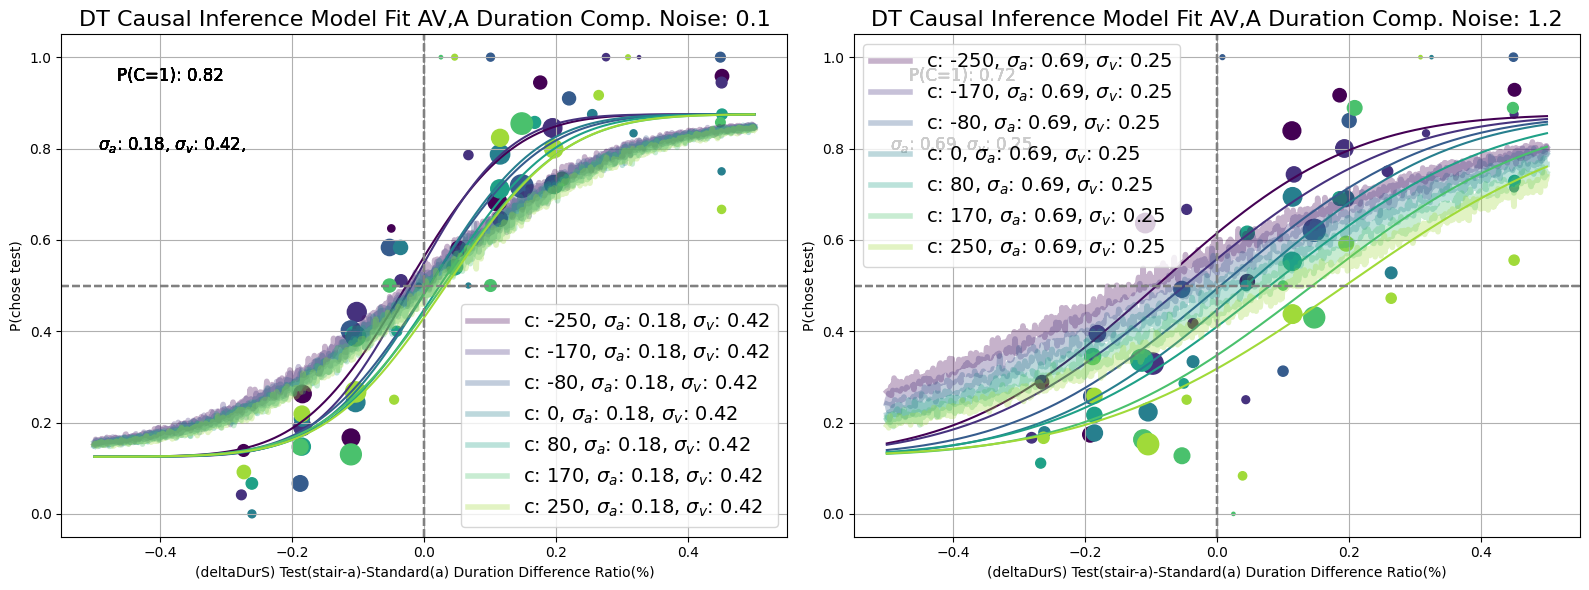

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns

plotPsychometrics_MC_Data(mc_fitter)

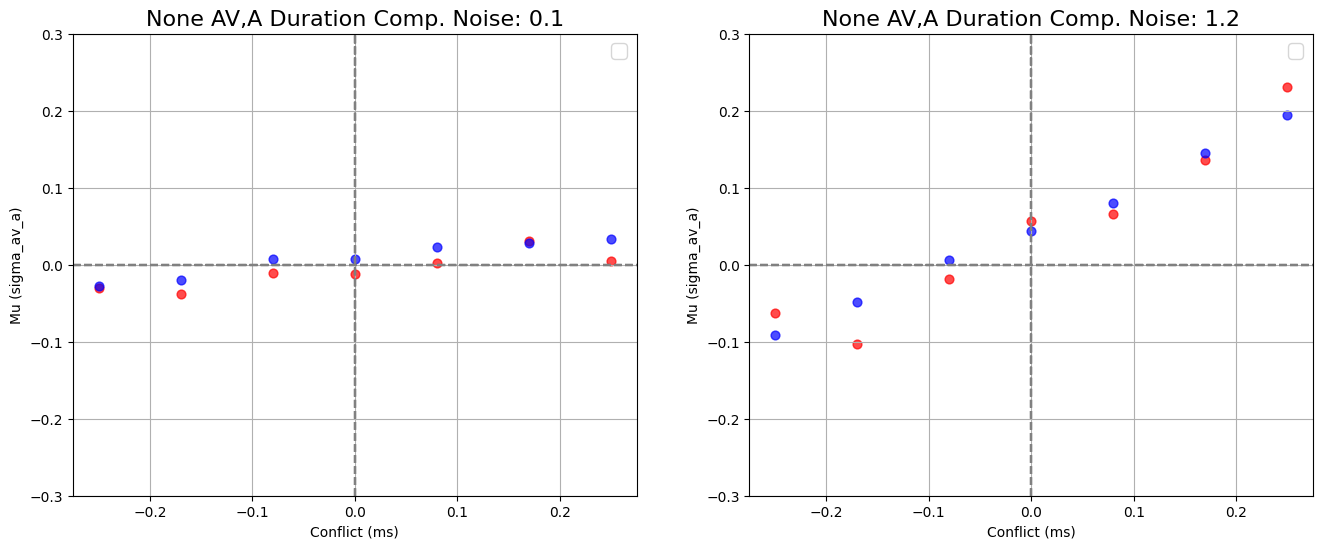

In [29]:
def plot_mu_vs_conflict_MC_vs_Data(self):
    plt.figure(figsize=(16, 6))
    for i, standardLevel in enumerate(self.uniqueStandard):
        for j, audioNoiseLevel in enumerate(sorted(self.uniqueSensory)):
            for k, conflictLevel in enumerate(self.uniqueConflict):
                plt.subplot(1, 2, j + 1)
                color = sns.color_palette("viridis", as_cmap=True)(k / len(self.uniqueConflict))
                
                paramsSimDf = self.getParams(self.simDataFit.x, conflictLevel, audioNoiseLevel)  # lambda mu sigma
                muModel = paramsSimDf[1]
                muData = self.getParams(self.dataFit.x, conflictLevel, audioNoiseLevel)[1]
                plt.scatter(conflictLevel, muData, color="red", s=40, alpha=0.7)
                plt.scatter(conflictLevel, muModel, color="blue", s=40,  alpha=0.7)
                plt.xlabel(f"Conflict (ms)")
                plt.ylabel("Mu (sigma_av_a)")
                plt.axhline(y=0, color='gray', linestyle='--')
                plt.axvline(x=0, color='gray', linestyle='--')
                plt.ylim(-0.3, 0.3)
                plt.title(f"{self.dataName} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)
                plt.legend(fontsize=14, title_fontsize=14)
                plt.grid()
    plt.show()
plot_mu_vs_conflict_MC_vs_Data(mc_fitter)

In [23]:
data

,Unnamed: 0,standardDur,audNoise,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,testDurSCheckBias,standardDurCheck,testDurSCompare,standardDurCompare,standard_dur,riseDur,logStandardDur,logConflictDur,logTestDur,logDeltaDur
0,0.0,0.5,0.1,1.0,0.22509,0.29178,0.86700,0.0,2.09247,-0.59,...,True,True,0.00139,0.0014,0.5,1,-0.693147,-1.386294,-1.568248,-0.875101
1,1.0,0.5,1.2,1.0,0.23342,0.33346,0.88368,1.0,2.15916,-0.59,...,True,True,0.00381,0.0037,0.5,1,-0.693147,-inf,-1.568248,-0.875101
2,2.0,0.5,1.2,1.0,0.24176,0.29178,0.52520,2.0,1.76734,-0.59,...,True,True,0.00331,0.0005,0.5,1,-0.693147,NaN,-1.568248,-0.875101
3,3.0,0.5,1.2,2.0,0.35014,0.43350,0.75863,3.0,2.25087,-0.59,...,True,True,0.00351,0.0034,0.5,1,-0.693147,-1.386294,-1.568248,-0.875101
4,4.0,0.5,1.2,1.0,0.26677,0.34180,0.40849,4.0,2.46762,0.90,...,True,True,0.00337,0.0035,0.5,1,-0.693147,-inf,-0.050904,0.642243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486,9.0,0.5,0.1,1.0,0.39640,0.41292,0.55331,9.0,2.81610,0.90,...,True,True,0.01029,0.0069,0.5,1,-0.693147,NaN,-0.051599,0.641549
2487,10.0,0.5,1.2,1.0,0.42118,0.41292,0.49550,10.0,2.12240,-0.42,...,True,True,0.00084,0.0014,0.5,1,-0.693147,-1.771957,-1.241190,-0.548043
2488,11.0,0.5,0.1,2.0,0.41292,0.28078,0.60286,11.0,2.75003,0.90,...,True,True,0.01099,0.0067,0.5,1,-0.693147,NaN,-0.051599,0.641549
2489,12.0,0.5,0.1,2.0,0.32208,0.39640,0.80932,12.0,2.32060,-0.42,...,True,True,0.00376,0.0062,0.5,1,-0.693147,-1.771957,-1.241190,-0.548043


In [ ]:
def simulateData(fittedParams,uniqueSensory,uniqueConflict, nSamples=10000):
	simData = []
	uniqueSensory = [0.1,1.2]
	for audioNoiseLevel in uniqueSensory:
		for conflictLevel in uniqueConflict:
			# Unpack fitted parameters
			lambda_, sigma_av_a, sigma_av_v, p_c = getParamsCausal(fittedParams, conflictLevel, audioNoiseLevel)
			# Simulate responses
			for _ in range(nSamples):
				S_a_s = 0.5
				S_v_s = S_a_s + conflictLevel
				S_a_t = S_a_s + np.random.uniform(-0.5, 0.5)
				S_v_t = S_v_s + np.random.uniform(-0.5, 0.5)
				trueStims = (S_a_s, S_a_t, S_v_s, S_v_t)
				p_test_longer = probTestLonger_vectorized_mc(trueStims, sigma_av_a, sigma_av_v, p_c, lambda_)
				chose_test = np.random.binomial(1, p_test_longer)
				simData.append({
					'standardDur': S_a_s,
					'testDurS': S_a_t,
					'deltaDurS': S_a_t - S_a_s,
					'unbiasedVisualStandardDur': S_v_s,
					'unbiasedVisualTestDur': S_v_t,
					'audNoise': audioNoiseLevel,
					'conflictDur': conflictLevel,
					'chose_test': chose_test,
					'chose_standard': 1 - chose_test,
					'responses': 1  # Assuming each sample is a response
				})
	simData = pd.DataFrame(simData)
	return simData
# Simulate psychometric data using fitted parameters
simulated_data = simulateData(fittedParams, uniqueSensory, uniqueConflict, nSamples=1000)


# Group and plot simulated psychometric
sim_grouped = groupByChooseTest(simulated_data, [intensityVariable, sensoryVar, standardVar, conflictVar, visualStandardVar, visualTestVar, audioTestVar])




In [ ]:

# def fitMultipleStartingPoints(data,nStart=3):
#     # group data and prepare for fitting
#     groupedData = groupByChooseTest(data,groupArgs=[intensityVariable, sensoryVar, standardVar, conflictVar])
#     global nLambda, nSensoryVar, nConflictVar, uniqueSensory, uniqueConflict
#     nSensoryVar = len(uniqueSensory)  # Number of sensory variables
#     nConflictVar = len(uniqueConflict)  # Number of conflict variables
#     uniqueSensory = data['audNoise'].unique()
#     uniqueConflict = sorted(data[conflictVar].unique())
	
#     levels = groupedData[intensityVariable].values
#     responses = groupedData['num_of_chose_test'].values
#     totalResp = groupedData['total_responses'].values
#     conflictLevels = groupedData[conflictVar].values
#     noiseLevels = groupedData[sensoryVar].values

#     # Prepare multiple initial guesses
#     singleInitGuesses = estimate_initial_guesses(levels, responses, totalResp)

#     multipleInitGuesses = multipleInitGuessesWEstimate(singleInitGuesses, nStart)

#     # Fit the model with multiple starting points
	
#     best_fit = None
#     best_nll = float('inf')  # Initialize with infinity
#     disable=False
#     if len(multipleInitGuesses)==1:
#         disable=True
	
#     for i in tqdm(range(len(multipleInitGuesses)), desc="Fitting multiple starting points",disable=disable):
		
#         fit = fitJoint(groupedData, initGuesses=multipleInitGuesses[i])
#         nll = nLLJoint(fit.x, levels, responses, totalResp, conflictLevels, noiseLevels)

#         if nll < best_nll:
#             best_nll = nll
#             best_fit = fit

#     return best_fit

fitModelSimData = fitMultipleStartingPoints(data, nStart=1)

NameError: name 'uniqueSensory' is not defined

KeyError: 'delta_dur_percents'

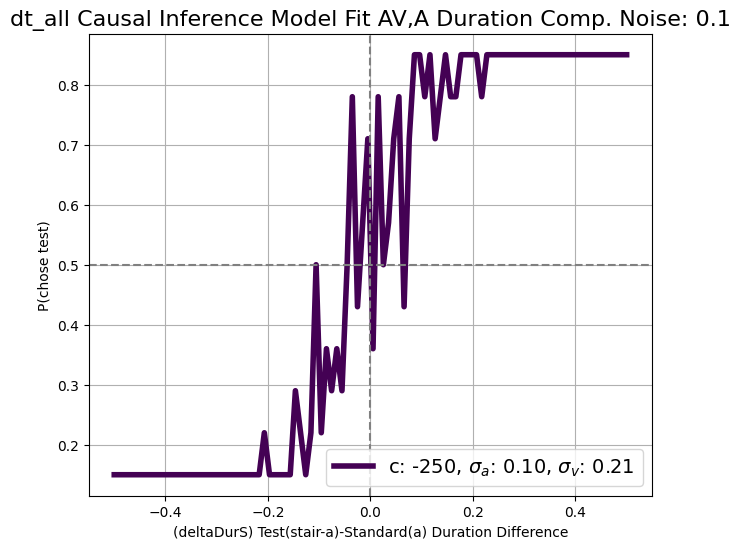

In [ ]:
    
# Plot results (existing plotting code continues from here...)
pltTitle = dataName + " Causal Inference Model Fit"
plt.figure(figsize=(16, 6))
for i, standardLevel in enumerate(uniqueStandard):
    for j, audioNoiseLevel in enumerate(sorted(uniqueSensory)):

        for k, conflictLevel in enumerate(uniqueConflict):
            plt.subplot(1, 2, j+1)
            lambda_, sigma_av_a, sigma_av_v, p_c = getParamsCausal(fittedParams, conflictLevel, audioNoiseLevel)
            x = np.linspace(-0.5, 0.5, 100)
            S_a_s=0.5
            #c_arr=np.full_like(x, conflictLevel)
            S_v_s= S_a_s+conflictLevel
            y= np.zeros_like(x)
            for i in range(len(x)):
                y[i] = probTestLonger([S_a_s,S_a_s+x[i],S_v_s,S_a_s+x[i]], sigma_av_a, sigma_av_v, p_c, lambda_)

            color = sns.color_palette("viridis", as_cmap=True)(k / len(uniqueConflict))
            plt.plot(x, y, color=color, label=f"c: {int(conflictLevel*1000)}, $\sigma_a$: {sigma_av_a:.2f}, $\sigma_v$: {sigma_av_v:.2f}", linewidth=4)
            
            plt.axvline(x=0, color='gray', linestyle='--')
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel(f"({intensityVariable}) Test(stair-a)-Standard(a) Duration Difference")
            plt.ylabel("P(chose test)")
            plt.title(f"{pltTitle} AV,A Duration Comp. Noise: {audioNoiseLevel}", fontsize=16)
            plt.legend(fontsize=14, title_fontsize=14)
            plt.grid()

            groupedData = groupByChooseTest(data[(data[standardVar] == standardLevel) & (data[sensoryVar] == audioNoiseLevel) & (data[conflictVar] == conflictLevel)], [intensityVariable, sensoryVar, standardVar, conflictVar,visualStandardVar, visualTestVar, audioTestVar])
            bin_and_plot(groupedData, bin_method='cut', bins=10, plot=True, color=color)
            plt.text(0.05, 0.8, f"$\sigma_a$: {sigma_av_a:.2f}, $\sigma_v$: {sigma_av_v:.2f},", fontsize=12, ha='left', va='top', transform=plt.gca().transAxes)
            plt.tight_layout()
            plt.grid(True)
            print(f"Noise: {audioNoiseLevel}, Conflict: {conflictLevel}, Lambda: {lambda_:.3f}, Sigma_a: {sigma_av_a:.3f}, Sigma_v: {sigma_av_v:.3f}, p_c: {p_c:.3f}")
        plt.text(0.15, 0.9, f"P(C=1): {p_c:.2f}", fontsize=12, ha='center', va='bottom', transform=plt.gca().transAxes)
plt.show()



In [ ]:


def plot_posterior_vs_conflict(data,fittedParams,snr_list=[1.2, 0.1]):

	delta_dur_values = data["deltaDurS"].values
	conflict_values = data["conflictDur"].values
	snr_values = data["audNoise"].values
	best_params = fittedParams  # Use the best fitted parameters from the previous fitting

	posterior_values = []
	for delta, conflict, snr in zip(delta_dur_values, conflict_values, snr_values):
		λ, σa, σv, pc = getParamsCausal(best_params, conflict, snr)
		S_std = 0.5
		S_test = S_std + delta
		S_v = S_std + conflict

		m_a = np.random.normal(S_std, σa)
		m_v = np.random.normal(S_v, σv)

		var_sum = σa**2 + σv**2
		likelihood_c1 = (1 / np.sqrt(2 * np.pi * var_sum)) * np.exp(-(m_a - m_v)**2 / (2 * var_sum))
		likelihood_c2 = norm.pdf(m_a, loc=S_std, scale=σa) * norm.pdf(m_v, loc=S_v, scale=σv)
		posterior = (likelihood_c1 * pc) / (likelihood_c1 * pc + likelihood_c2 * (1 - pc))

		posterior_values.append(posterior)
	posterior_values = np.array(posterior_values)

	"""
	Plot posterior probability vs conflict for given SNR values.
	snr_list: list of SNR values to plot (default: [1.2, 0.1])
	"""
	plt.figure(figsize=(8, 5))
	for idx, noisy_snr_value in enumerate(snr_list):
		mask_noisy = np.isclose(snr_values, noisy_snr_value)
		conflicts_noisy = conflict_values[mask_noisy]
		posteriors_noisy = np.array(posterior_values)[mask_noisy]
		print(f" Posteriors: {posteriors_noisy}")
		print(f" Conflicts: {conflicts_noisy}")
		plt.subplot(1, 2, idx + 1)
		plt.scatter(conflicts_noisy * 1000, posteriors_noisy, alpha=0.6, label=f'Posterior P(C=1) (SNR={noisy_snr_value})')
		# also plot the mean posterior probability for the noisy SNR value for each conflict
		# Calculate mean posterior for each unique conflict value at this SNR
		unique_conflicts = np.unique(conflicts_noisy)
		mean_posteriors = [posteriors_noisy[conflicts_noisy == c].mean() for c in unique_conflicts]
		plt.plot(unique_conflicts * 1000, mean_posteriors, color='black', linewidth=2, marker='o', label='Mean Posterior')
		
		plt.xlabel('Conflict (ms)')
		plt.ylabel('Posterior Probability of Common Cause')
		plt.title(f'Posterior P(C=1) vs Conflict (SNR={noisy_snr_value})')
		# Use the mean P(C=1) for the axhline
		p_c_mean = np.mean([getParamsCausal(fittedParams, c, noisy_snr_value)[3] for c in conflicts_noisy])
		plt.axhline(y=p_c_mean, color='gray', linestyle='--', label=f'Mean P(C=1)={p_c_mean:.2f}')
		plt.legend()
		plt.ylim(0, 1)
		plt.grid()
	plt.tight_layout()
	plt.show()

# Plot posterior vs conflict for SNR values 1.2 and 0.1
plot_posterior_vs_conflict(data,fittedParams,snr_list=[ 0.1,1.2])


NameError: name 'fittedParams' is not defined

In [ ]:
def calculate_mu_from_data_and_model(data, fittedParams):
	"""
	Calculate mu (PSE) from both data and model predictions for each SNR and conflict condition.
	"""
	# Get unique conditions
	unique_snr = sorted(data['audNoise'].unique())
	unique_conflict = sorted(data['conflictDur'].unique())
	
	mu_data = {}
	mu_model = {}
	
	# Calculate mu for each condition
	for snr in unique_snr:
		mu_data[snr] = {}
		mu_model[snr] = {}
		
		for conflict in unique_conflict:
			# Filter data for current condition
			condition_data = data[(data['audNoise'] == snr) & (data['conflictDur'] == conflict)]
			
			if len(condition_data) > 0:
				# Group data by delta duration
				grouped = condition_data.groupby('deltaDurS').agg({
					'chose_test': 'sum',
					'responses': 'count'
				}).reset_index()
				grouped['p_choose_test'] = grouped['chose_test'] / grouped['responses']
				
				# Fit psychometric function to get mu from data
				if len(grouped) > 3:  # Need enough points to fit
					try:
						# Estimate initial guesses
						init_guess = estimate_initial_guesses(
							grouped['deltaDurS'].values,
							grouped['chose_test'].values,
							grouped['responses'].values
						)
						
						# Fit psychometric function
						fitted_params_data = fit_psychometric_function(
							grouped['deltaDurS'].values,
							grouped['chose_test'].values,
							grouped['responses'].values,
							init_guess
						)
						mu_data[snr][conflict] = fitted_params_data[1]  # mu is second parameter
						
					except:
						mu_data[snr][conflict] = np.nan
				else:
					mu_data[snr][conflict] = np.nan
				
				# Get mu from causal inference model
				lambda_, sigma_av_a, sigma_av_v, p_c = getParamsCausal(fittedParams, conflict, snr)
				
				# Calculate model's effective mu by finding where P(choose test) = 0.5
				delta_range = np.linspace(-0.5, 0.5, 1000)
				p_values = []
				
				for delta in delta_range:
					p = probTestLonger_vectorized(delta, conflict, lambda_, sigma_av_a, sigma_av_v, p_c)
					p_values.append(p)
				
				p_values = np.array(p_values)
				# Find delta where p is closest to 0.5
				idx_closest = np.argmin(np.abs(p_values - 0.5))
				mu_model[snr][conflict] = delta_range[idx_closest]
			
			else:
				mu_data[snr][conflict] = np.nan
				mu_model[snr][conflict] = np.nan
	
	return mu_data, mu_model

def plot_mu_comparison(mu_data, mu_model, unique_snr, unique_conflict):
	"""
	Plot comparison of mu values from data vs model predictions.
	"""
	fig, axes = plt.subplots(1, 2, figsize=(15, 6))
	
	colors = sns.color_palette("viridis", n_colors=len(unique_conflict))
	
	for i, snr in enumerate(unique_snr):
		ax = axes[i]
		
		conflicts_plot = []
		mu_data_plot = []
		mu_model_plot = []
		
		for j, conflict in enumerate(unique_conflict):
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				conflicts_plot.append(conflict * 1000)  # Convert to ms
				mu_data_plot.append(mu_data[snr][conflict] * 1000)  # Convert to ms
				mu_model_plot.append(mu_model[snr][conflict] * 1000)  # Convert to ms
		
		if conflicts_plot:
			# Plot data mu
			ax.scatter(conflicts_plot, mu_data_plot, 
					  color='red', s=100, alpha=0.7, 
					  label='Data μ (PSE)', marker='o')
			
			# Plot model mu
			ax.scatter(conflicts_plot, mu_model_plot, 
					  color='blue', s=100, alpha=0.7, 
					  label='Model μ (PSE)', marker='s')
			
			# Connect corresponding points
			for k in range(len(conflicts_plot)):
				ax.plot([conflicts_plot[k], conflicts_plot[k]], 
					   [mu_data_plot[k], mu_model_plot[k]], 
					   'gray', alpha=0.5, linestyle='--')
		
		ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
		ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
		ax.set_xlabel('Visual Conflict (ms)')
		ax.set_ylabel('μ (PSE) (ms)')
		ax.set_title(f'Data vs Model μ (SNR={snr})')
		# limits
		ax.set_ylim(-300, 300)
		ax.legend()
		ax.grid(True, alpha=0.3)
	
	plt.tight_layout()
	plt.show()
	
	# Print numerical comparison
	print("\n=== Mu (PSE) Comparison: Data vs Model ===")
	print("SNR\tConflict(ms)\tData μ(ms)\tModel μ(ms)\tDifference(ms)")
	print("-" * 60)
	
	for snr in unique_snr:
		for conflict in unique_conflict:
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				data_mu_ms = mu_data[snr][conflict] * 1000
				model_mu_ms = mu_model[snr][conflict] * 1000
				diff_ms = data_mu_ms - model_mu_ms
				print(f"{snr}\t{conflict*1000:.0f}\t\t{data_mu_ms:.2f}\t\t{model_mu_ms:.2f}\t\t{diff_ms:.2f}")

def plot_mu_vs_conflict_detailed(mu_data, mu_model, unique_snr, unique_conflict):
	"""
	Create a more detailed plot showing mu vs conflict with trend lines.
	"""
	plt.figure(figsize=(12, 8))
	
	for i, snr in enumerate(unique_snr):
		plt.subplot(2, 2, i+1)
		
		conflicts_ms = []
		mu_data_ms = []
		mu_model_ms = []
		
		for conflict in unique_conflict:
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				conflicts_ms.append(conflict * 1000)
				mu_data_ms.append(mu_data[snr][conflict] * 1000)
				mu_model_ms.append(mu_model[snr][conflict] * 1000)
		
		if conflicts_ms:
			# Plot with trend lines
			plt.plot(conflicts_ms, mu_data_ms, 'ro-', linewidth=2, markersize=8, 
					label='Data μ', alpha=0.8)
			plt.plot(conflicts_ms, mu_model_ms, 'bs-', linewidth=2, markersize=8, 
					label='Model μ', alpha=0.8)
			
			# Calculate correlation
			if len(conflicts_ms) > 2:
				corr_data = np.corrcoef(conflicts_ms, mu_data_ms)[0,1]
				corr_model = np.corrcoef(conflicts_ms, mu_model_ms)[0,1]
				plt.text(0.05, 0.95, f'Data r={corr_data:.3f}\nModel r={corr_model:.3f}', 
						transform=plt.gca().transAxes, fontsize=10,
						verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
		
		plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
		plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
		plt.xlabel('Visual Conflict (ms)')
		plt.ylabel('μ (PSE) (ms)')
		plt.title(f'μ vs Conflict (SNR={snr})')
		plt.legend()
		plt.grid(True, alpha=0.3)
		plt.ylim(-300, 300)
	
	# Correlation plot
	plt.subplot(2, 2, len(unique_snr)+1)
	all_data_mu = []
	all_model_mu = []
	
	for snr in unique_snr:
		for conflict in unique_conflict:
			if not np.isnan(mu_data[snr][conflict]) and not np.isnan(mu_model[snr][conflict]):
				all_data_mu.append(mu_data[snr][conflict] * 1000)
				all_model_mu.append(mu_model[snr][conflict] * 1000)
	
	if all_data_mu:
		plt.scatter(all_data_mu, all_model_mu, s=100, alpha=0.7)
		
		# Add diagonal line (perfect correlation)
		min_val = min(min(all_data_mu), min(all_model_mu))
		max_val = max(max(all_data_mu), max(all_model_mu))
		plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect correlation')
		
		# Calculate overall correlation
		overall_corr = np.corrcoef(all_data_mu, all_model_mu)[0,1]
		plt.text(0.05, 0.95, f'Overall r={overall_corr:.3f}', 
				transform=plt.gca().transAxes, fontsize=12,
				verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
		
		plt.xlabel('Data μ (ms)')
		plt.ylabel('Model μ (ms)')
		plt.title('Data vs Model μ Correlation')
		plt.legend()
		plt.grid(True, alpha=0.3)
		plt.ylim(-300, 300)
	
	plt.tight_layout()
	plt.show()

# Calculate mu from both data and model
print("Calculating mu (PSE) from data and model predictions...")
mu_data, mu_model = calculate_mu_from_data_and_model(data, fittedParams)

# Get unique values for plotting
unique_snr = sorted(data['audNoise'].unique())
unique_conflict = sorted(data['conflictDur'].unique())

# Create comparison plots
plot_mu_comparison(mu_data, mu_model, unique_snr, unique_conflict)
plot_mu_vs_conflict_detailed(mu_data, mu_model, unique_snr, unique_conflict)

Calculating mu (PSE) from data and model predictions...


NameError: name 'probTestLonger_vectorized' is not defined